# Trading Strategy & Backtesting
**Date:** February 2026  
**Objective:** To implement and backtest trading strategy for a selected stock using Python, Pandas, and Vectorized operations.

In [15]:
pip install numpy pandas yfinance matplotlib plotly ipython nbformat nbconvert

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [16]:
import numpy as np
import pandas as pd
import yfinance as yf;

Importing chosen stock data from yfinance

In [17]:
goog = yf.Ticker("GOOG")
google_five_year_history = goog.history(period='5y')

In [18]:
window = 140 #20 week
google_five_year_history['SMA'] = google_five_year_history['Close'].rolling(window=window).mean()       # Simple Moving Average
google_five_year_history['Vol'] = google_five_year_history['Close'].std()        # Rolling Volatility

In [19]:
# baseline log returns from jsut holding
google_five_year_history['Log_Ret'] = np.log(google_five_year_history['Close']/ google_five_year_history['Close'].shift(1))

In [20]:
google_five_year_history

,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA,Vol,Log_Ret
Date,,,,,,,,,,
2021-02-26 00:00:00-05:00,101.762761,102.779632,100.052588,101.084846,41670000,0.0,0.0,NaN,53.974247,NaN
2021-03-01 00:00:00-05:00,102.060525,103.549359,101.543408,103.300728,28090000,0.0,0.0,NaN,53.974247,0.021684
2021-03-02 00:00:00-05:00,103.036704,104.435212,102.792041,103.019333,22692000,0.0,0.0,NaN,53.974247,-0.002728
2021-03-03 00:00:00-05:00,102.591058,103.648534,99.751856,100.581139,29684000,0.0,0.0,NaN,53.974247,-0.023952
2021-03-04 00:00:00-05:00,100.415373,103.684351,100.261521,101.691795,42360000,0.0,0.0,NaN,53.974247,0.010982
...,...,...,...,...,...,...,...,...,...,...
2026-02-19 00:00:00-05:00,302.519989,306.029999,300.670013,303.559998,13448600,0.0,0.0,275.776270,53.974247,-0.001251
2026-02-20 00:00:00-05:00,304.799988,316.760010,304.420013,314.899994,33663100,0.0,0.0,276.650112,53.974247,0.036676
2026-02-23 00:00:00-05:00,319.140015,319.454987,309.989990,311.690002,17641200,0.0,0.0,277.521779,53.974247,-0.010246


### Setting sell/purchase signal
In a momentum trading signal there are one thing to focus on: the ATR (average true range). The concept is as follows:
* Calculate the ATR (Average True Range) to measure volatility.
* Identify a "squeeze" using the ATR: When the current ATR is lower than the 30-day average ATR (it signals a consolidation period or a squeeze)
* Buy Signal: If Price breaks the Highest High of the last 20 days + 1 ATR, BUY.
* Exit Signal: If Price falls below the Lowest Low of the last 10 days, SELL.

What is an ATR?
* True Range (TR) looks at the greatest of three distances: Today's High to Today's Low, Yesterday's Close to Today's High, Yesterday's Close to Today's Low.
    * The reason for this rather than just looking at the intraday highs and lows is to avoid missing out any overnight trading effects
* ATR is simply the moving average (usually 14 days) of those True Range values.

Identifying the squeeze
$$ Current ATR<30-Day Average ATR $$

Identifying the buy signal
* The 20-Day High: This is a classic "Donchian Channel" breakout. If the price reaches a new 20-day high, it is a of a possible breakout
* The "+ 1 ATR" (The Noise Filter): By requiring the price to break the high plus one full unit of average volatility (ATR), you are ensuring the move has real power behind it.

Identifying the exit signal
* The lowest low in the past 10 days, natural the periods set are variable due to "Stock Personalities"

In [21]:
# calculate ATR
# TR = Max(High-Low, |High-PrevClose|, |Low-PrevClose|)

google_five_year_history['H-L'] = google_five_year_history['High'] - google_five_year_history['Low']
google_five_year_history['H-PC'] = abs(google_five_year_history['High'] - google_five_year_history['Close'].shift(1))
google_five_year_history['L-PC'] = abs(google_five_year_history['Low'] - google_five_year_history['Close'].shift(1))
google_five_year_history['TR'] = google_five_year_history[['H-L', 'H-PC', 'L-PC']].max(axis=1)
google_five_year_history['ATR'] = google_five_year_history['TR'].rolling(window=14).mean()

In [22]:
# identifying the squeeze
# Current ATR < 30-day Average ATR
google_five_year_history['ATR_MA30'] = google_five_year_history['ATR'].rolling(window=30).mean()
google_five_year_history['Squeeze'] = google_five_year_history['ATR'] < google_five_year_history['ATR_MA30']

In [25]:
# Entry: 20-day High + 1 ATR
# Exit: 10-day Low
google_five_year_history['Rolling_High_20'] = google_five_year_history['High'].rolling(window=20).max()
google_five_year_history['Rolling_Low_10'] = google_five_year_history['Low'].rolling(window=10).min()

In [30]:
# We use shift(1) to avoid look-ahead bias (trading on yesterday's signals)
entry_condition = (google_five_year_history['Close'] > google_five_year_history['Rolling_High_20'].shift(1) + google_five_year_history['ATR']) & (google_five_year_history['Squeeze'] == True)

exit_condition = (google_five_year_history['Close'] < google_five_year_history['Rolling_Low_10'].shift(1))

# Initialize Position column
google_five_year_history['Position'] = 0

# Vectorized logic to determine "In the market" (1) or "Out" (0)
# Since this strategy has a specific exit rule, we iterate to handle the state
pos = 0
positions = []
for i in range(len(google_five_year_history)):
    if entry_condition.iloc[i]:
        pos = 1
    elif exit_condition.iloc[i]:
        pos = 0
    positions.append(pos)

google_five_year_history['Position'] = positions

In [32]:
# calculating strategy returns
google_five_year_history['Strategy_Ret'] = (google_five_year_history['Position'].shift(1) * google_five_year_history['Log_Ret'])
google_five_year_history['Cum_Ret'] = google_five_year_history['Strategy_Ret'].cumsum().apply(np.exp)

In [33]:
google_five_year_history


,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA,Vol,Log_Ret,...,L-PC,TR,ATR,ATR_MA30,Squeeze,Rolling_High_20,Rolling_Low_10,Position,Strategy_Ret,Cum_Ret
Date,,,,,,,,,,,,,,,,,,,,,
2021-02-26 00:00:00-05:00,101.762761,102.779632,100.052588,101.084846,41670000,0.0,0.0,NaN,53.974247,NaN,...,NaN,2.727044,NaN,NaN,False,NaN,NaN,0,NaN,NaN
2021-03-01 00:00:00-05:00,102.060525,103.549359,101.543408,103.300728,28090000,0.0,0.0,NaN,53.974247,0.021684,...,0.458561,2.464512,NaN,NaN,False,NaN,NaN,0,0.0,1.000000
2021-03-02 00:00:00-05:00,103.036704,104.435212,102.792041,103.019333,22692000,0.0,0.0,NaN,53.974247,-0.002728,...,0.508687,1.643171,NaN,NaN,False,NaN,NaN,0,-0.0,1.000000
2021-03-03 00:00:00-05:00,102.591058,103.648534,99.751856,100.581139,29684000,0.0,0.0,NaN,53.974247,-0.023952,...,3.267477,3.896678,NaN,NaN,False,NaN,NaN,0,-0.0,1.000000
2021-03-04 00:00:00-05:00,100.415373,103.684351,100.261521,101.691795,42360000,0.0,0.0,NaN,53.974247,0.010982,...,0.319618,3.422830,NaN,NaN,False,NaN,NaN,0,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-02-19 00:00:00-05:00,302.519989,306.029999,300.670013,303.559998,13448600,0.0,0.0,275.776270,53.974247,-0.001251,...,3.269989,5.359985,10.267853,8.591465,False,350.149994,296.899994,0,-0.0,1.199763
2026-02-20 00:00:00-05:00,304.799988,316.760010,304.420013,314.899994,33663100,0.0,0.0,276.650112,53.974247,0.036676,...,0.860016,13.200012,10.664283,8.732119,False,350.149994,296.899994,0,0.0,1.199763
2026-02-23 00:00:00-05:00,319.140015,319.454987,309.989990,311.690002,17641200,0.0,0.0,277.521779,53.974247,-0.010246,...,4.910004,9.464996,10.686425,8.881119,False,350.149994,296.899994,0,-0.0,1.199763


In [34]:
clean_df = google_five_year_history.dropna()

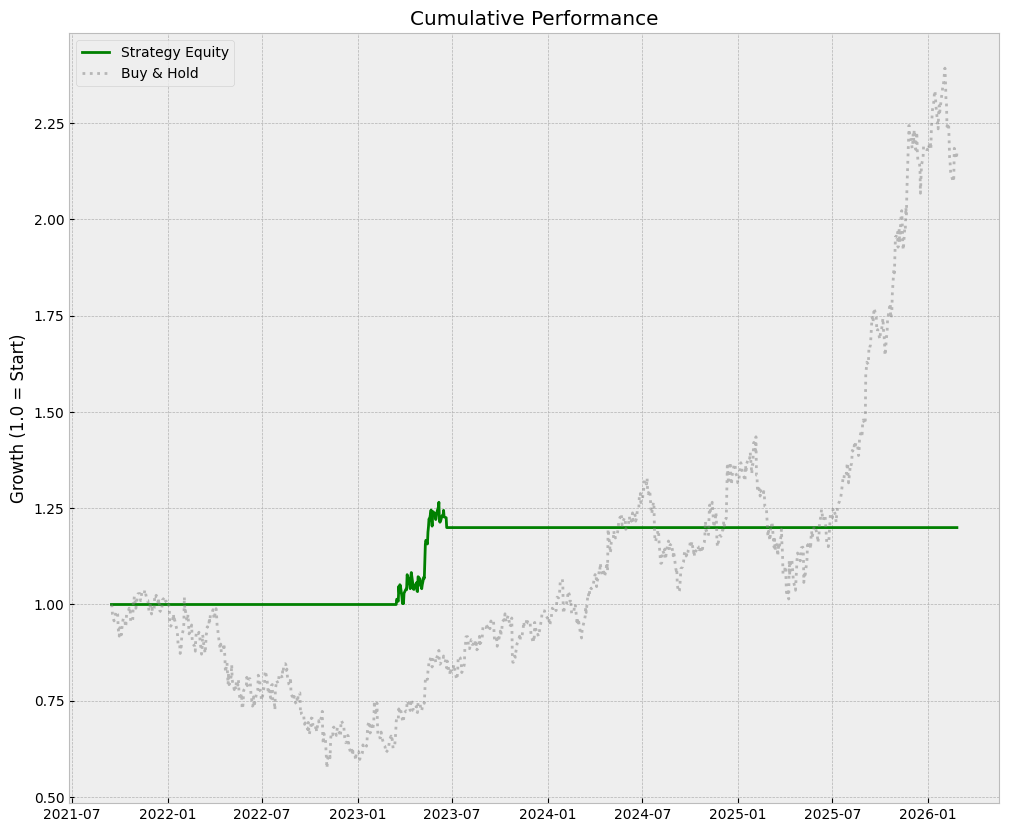

In [37]:
import matplotlib.pyplot as plt

plt.style.use('bmh') 
fig, (ax2) = plt.subplots(1, 1, figsize=(12, 10), sharex=True)
buy_and_hold = clean_df['Close'] / clean_df['Close'].iloc[0]
ax2.plot(clean_df.index, clean_df['Cum_Ret'], label='Strategy Equity', color='green', linewidth=2)
ax2.plot(clean_df.index, buy_and_hold, label='Buy & Hold', color='gray', linestyle=':', alpha=0.5)
ax2.set_ylabel('Growth (1.0 = Start)')
ax2.set_title('Cumulative Performance')
ax2.legend(loc='upper left')